Kernel ini menunjukkan visualisasi dasar data menggunakan peta Choropleth. Selanjutnya, ia mencoba untuk mengelompokkan data menggunakan beberapa algoritma pengelompokan termasuk K-means dan Guassian Mixture Model berdasarkan beberapa faktor seperti PDB per kapita, harapan hidup, korupsi, dll.

In [1]:
#Nama : Moh Aji Prasetyo
#NIM : 17.01.53.0047
#Call required libraries
import time                   # To time processes
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulatio 
import matplotlib.pyplot as plt                   # For graphics
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size


In [2]:
wh = pd.read_csv("../input/2017.csv") #Read the dataset
wh.describe()

,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,78.000000,5.354019,5.452326,5.255713,0.984718,1.188898,0.551341,0.408786,0.246883,0.123120,1.850238
std,44.888751,1.131230,1.118542,1.145030,0.420793,0.287263,0.237073,0.149997,0.134780,0.101661,0.500028
min,1.000000,2.693000,2.864884,2.521116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377914
25%,39.500000,4.505500,4.608172,4.374955,0.663371,1.042635,0.369866,0.303677,0.154106,0.057271,1.591291
50%,78.000000,5.279000,5.370032,5.193152,1.064578,1.253918,0.606042,0.437454,0.231538,0.089848,1.832910
75%,116.500000,6.101500,6.194600,6.006527,1.318027,1.414316,0.723008,0.516561,0.323762,0.153296,2.144654
max,155.000000,7.537000,7.622030,7.479556,1.870766,1.610574,0.949492,0.658249,0.838075,0.464308,3.117485


In [3]:
print("Dimension of dataset: wh.shape")
wh.dtypes

Dimension of dataset: wh.shape


Country                           object
Happiness.Rank                     int64
Happiness.Score                  float64
Whisker.high                     float64
Whisker.low                      float64
Economy..GDP.per.Capita.         float64
Family                           float64
Health..Life.Expectancy.         float64
Freedom                          float64
Generosity                       float64
Trust..Government.Corruption.    float64
Dystopia.Residual                float64
dtype: object

**Basic Visualization**

*Correlation among variables*

Pertama, kita akan mencoba memahami korelasi antara beberapa variabel. Untuk ini, pertama-tama hitung matriks korelasi antar variabel dan diplot sebagai peta panas.

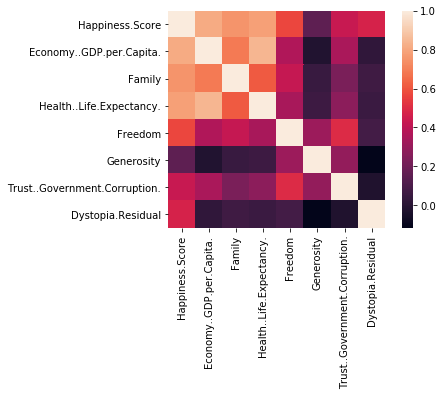

In [4]:
wh1 = wh[['Happiness.Score','Economy..GDP.per.Capita.','Family','Health..Life.Expectancy.', 'Freedom', 
          'Generosity','Trust..Government.Corruption.','Dystopia.Residual']] #Subsetting the data
cor = wh1.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

Kami telah memperoleh peta panas korelasi antar variabel. Palet warna di samping mewakili jumlah korelasi antar variabel. Warna yang lebih terang menunjukkan korelasi yang tinggi. Kita bisa melihat bahwa skor kebahagiaan sangat berkorelasi dengan PDB per kapita, keluarga, dan harapan hidup. Ini paling tidak berkorelasi dengan kemurahan hati.

Kami akan mencoba merencanakan skor kebahagiaan negara-negara di peta dunia. Mengarahkan mouse ke atas negara akan menampilkan nama negara serta skor kebahagiaannya.

In [5]:
#Ref: https://plot.ly/python/choropleth-maps/
data = dict(type = 'choropleth', 
           locations = wh['Country'],
           locationmode = 'country names',
           z = wh['Happiness.Score'], 
           text = wh['Country'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'Happiness Index 2017', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

**Clustering Of Countries**

Kami sedang mempertimbangkan delapan parameter, yaitu, skor kebahagiaan, PDB per kapita, keluarga, harapan hidup, kebebasan, kemurahan hati, korupsi dan sisa distopia untuk mengelompokkan negara. Karena pengelompokan sensitif terhadap berbagai data. Disarankan untuk menskalakan data sebelum melanjutkan. 

In [6]:
#Scaling of data
ss = StandardScaler()
ss.fit_transform(wh1)

array([[ 1.93599602,  1.50618765,  1.20357658, ...,  0.8569643 ,
         1.90308437,  0.85629599],
       [ 1.92269283,  1.18651768,  1.26503623, ...,  0.80685634,
         2.73999784,  0.92989102],
       [ 1.90672969,  1.1823454 ,  1.47266877, ...,  1.70201314,
         0.30006609,  0.94796425],
       ..., 
       [-1.77816933, -1.12910094, -0.51306362, ...,  0.79923322,
        -0.56334657, -2.4660431 ],
       [-2.17193469, -2.12929212, -1.95262416, ..., -0.31596505,
        -0.38459935, -0.33549229],
       [-2.35994869, -2.34773594, -4.15212515, ...,  0.253028  ,
        -0.65680192,  0.43290816]])

**(1) k-means clustering**

Secara umum, k-means adalah pilihan pertama untuk clustering karena kesederhanaannya. Di sini, pengguna harus menentukan jumlah cluster (Posting tentang cara memutuskan jumlah cluster akan ditangani nanti). Cluster dibentuk berdasarkan kedekatan dengan nilai center cluster. Nilai tengah awal dipilih secara acak. K-means clustering adalah pendekatan top-down, dalam artian kita menentukan jumlah cluster (k) kemudian mengelompokkan titik-titik data tersebut ke dalam cluster k.

In [7]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(wh1, 2)
kmeans = pd.DataFrame(clust_labels)
wh1.insert((wh1.shape[1]),'kmeans',kmeans)




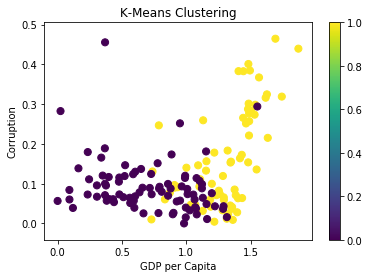

In [8]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)

**(2) Agglomerative Clustering**

Juga dikenal sebagai pengelompokan hierarki, tidak mengharuskan pengguna untuk menentukan jumlah kluster. Awalnya, setiap titik dianggap sebagai cluster terpisah, kemudian secara rekursif mengelompokkan titik-titik tersebut bersama-sama tergantung pada jarak di antara mereka. Titik-titik tersebut dikelompokkan sedemikian rupa sehingga jarak antar titik dalam suatu cluster minimal dan jarak antar cluster maksimal. Ukuran jarak yang umum digunakan adalah jarak Euclidean, jarak Manhattan atau jarak Mahalanobis. Tidak seperti pengelompokan k-means, ini adalah pendekatan "bottom-up".

Tip Python: Meskipun memberikan jumlah cluster tidak diperlukan tetapi Python menyediakan opsi untuk menyediakan yang sama untuk penggunaan yang mudah dan sederhana.

In [9]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(X)
    return (clust_labels1)

clust_labels1 = doAgglomerative(wh1, 2)
agglomerative = pd.DataFrame(clust_labels1)
wh1.insert((wh1.shape[1]),'agglomerative',agglomerative)

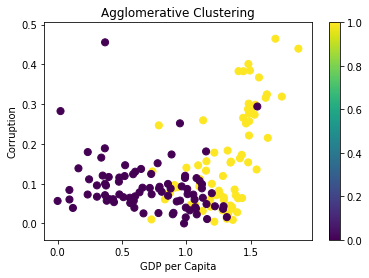

In [10]:
#Plot the clusters obtained using Agglomerative clustering or Hierarchical clustering
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=agglomerative[0],s=50)
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)

**(3) Affinity Propagation**

Ini tidak memerlukan jumlah cluster untuk diperkirakan dan disediakan sebelum memulai algoritma. Itu tidak membuat asumsi tentang struktur internal dari titik data.

In [11]:
def doAffinity(X):
    model = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
    model.fit(X)
    clust_labels2 = model.predict(X)
    cent2 = model.cluster_centers_
    return (clust_labels2, cent2)

clust_labels2, cent2 = doAffinity(wh1)
affinity = pd.DataFrame(clust_labels2)
wh1.insert((wh1.shape[1]),'affinity',affinity)

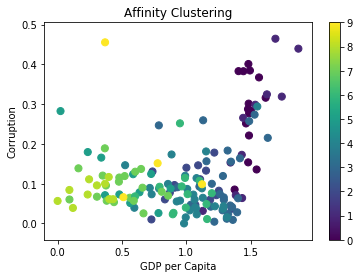

In [12]:
#Plotting the cluster obtained using Affinity algorithm
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=affinity[0],s=50)
ax.set_title('Affinity Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)

**(4) Guassian Mixture Modelling**

Ini adalah clustering berbasis probabilistik atau clusterig berbasis estimasi kepadatan kernel. Cluster dibentuk berdasarkan distribusi pusat-pusat Gaussian.

In [13]:
def doGMM(X, nclust=2):
    model = GaussianMixture(n_components=nclust,init_params='kmeans')
    model.fit(X)
    clust_labels3 = model.predict(X)
    return (clust_labels3)

clust_labels3 = doGMM(wh1,2)
gmm = pd.DataFrame(clust_labels3)
wh1.insert((wh1.shape[1]),'gmm',gmm)

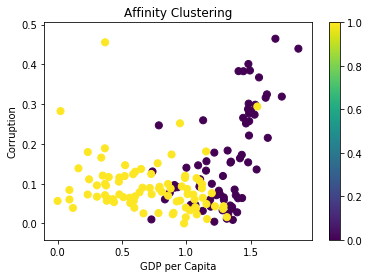

In [14]:
#Plotting the cluster obtained using GMM
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=gmm[0],s=50)
ax.set_title('Affinity Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)

**Visualisasi negara berdasarkan hasil clustering**

*(1) k-Means algorithm*

In [15]:
wh1.insert(0,'Country',wh.iloc[:,0])
wh1.iloc[:,[0,9,10,11,12]]
data = [dict(type='choropleth',
             locations = wh1['Country'],
             locationmode = 'country names',
             z = wh1['kmeans'],
             text = wh1['Country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Clustering of Countries based on K-Means',
              geo=dict(showframe = False,
                       projection = {'type':'Mercator'}))
map1 = go.Figure(data = data, layout=layout)
iplot(map1)

*(2) Agglomerative Clustering*

In [16]:
data = [dict(type='choropleth',
             locations = wh1['Country'],
             locationmode = 'country names',
             z = wh1['agglomerative'],
             text = wh1['Country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Grouping of Countries based on Agglomerative Clustering',
              geo=dict(showframe = False, 
                       projection = {'type':'Mercator'}))
map2 = dict(data=data, layout=layout)
iplot(map2)

*(3) Affinity Propagation*

In [17]:
data = [dict(type='choropleth',
             locations = wh1['Country'],
             locationmode = 'country names',
             z = wh1['affinity'],
             text = wh1['Country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Grouping of Countries based on Affinity Clustering',
              geo=dict(showframe = False, projection = {'type':'Mercator'}))
map3 = dict(data=data, layout=layout)
iplot(map3)

*(4) GMM*

In [18]:
data = [dict(type='choropleth',
             locations = wh1['Country'],
             locationmode = 'country names',
             z = wh1['gmm'],
             text = wh1['Country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Grouping of Countries based on GMM clustering',
              geo=dict(showframe = False, projection = {'type':'Mercator'}))
map4 = dict(data=data, layout=layout)
iplot(map4)

Analisis visual cepat peta panas pengelompokan negara menunjukkan bahwa k-means, Agglomerative dan GMM memberikan hasil yang serupa. Pengelompokan penyebaran afinitas telah mengelompokkan negara menjadi 10 kelompok. Karena pengelompokan adalah algoritme pembelajaran yang tidak diawasi dan karena tidak ada pengelompokan / target yang disediakan dalam kumpulan data, kami tidak dapat menganalisis algoritme mana yang berkinerja lebih baik.

Jika tidak, model terbaik untuk data kita dapat ditentukan menggunakan metrik seperti Informasi Mutual yang Dinormalisasi dan Skor Rand yang Disesuaikan.